# Código Python - Trabalho 2

## *Imports* estáticos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## 4.1  Análise Exploratória de Dados
### 4.1.1   Leitura do ficheiro

In [2]:
dados = pd.read_csv('../../dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']).rename(columns={"Value":"Premature_Deaths"})
#dados = dados[dados.Country != 'All Countries']
#dados.sort_values(by=['Value'])

#### Sumário dos dados

In [3]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49140 entries, 0 to 49139
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       49140 non-null  object 
 1   NUTS_Code                     49140 non-null  object 
 2   Air_Pollutant                 49140 non-null  object 
 3   Outcome                       49140 non-null  object 
 4   Affected_Population           49140 non-null  float64
 5   Populated_Area[km2]           49140 non-null  float64
 6   Air_Pollution_Average[ug/m3]  49140 non-null  float64
 7   Premature_Deaths              49140 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.0+ MB
None


### 4.1.2   Exploração com gráficos

In [4]:
dados.describe()

,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
count,4.914000e+04,4.914000e+04,49140.000000,49140.000000
mean,1.023692e+06,6.534426e+03,15.138166,366.798657
std,9.085726e+06,5.661679e+04,22.579360,5494.481929
min,2.674000e+03,2.000000e+00,0.100000,0.000000
25%,1.069040e+05,5.697000e+02,7.200000,3.000000
50%,2.388280e+05,1.340100e+03,8.900000,23.000000
75%,5.988800e+05,4.215200e+03,11.400000,112.000000
max,4.680626e+08,2.687568e+06,125.700000,740933.000000


In [5]:
features = list(dados.columns[0:8])
print(features)

['Country', 'NUTS_Code', 'Air_Pollutant', 'Outcome', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']


In [6]:
numericFeatures = features[4:]
numericFeatures

['Affected_Population',
 'Populated_Area[km2]',
 'Air_Pollution_Average[ug/m3]',
 'Premature_Deaths']

#### Análise Univariável

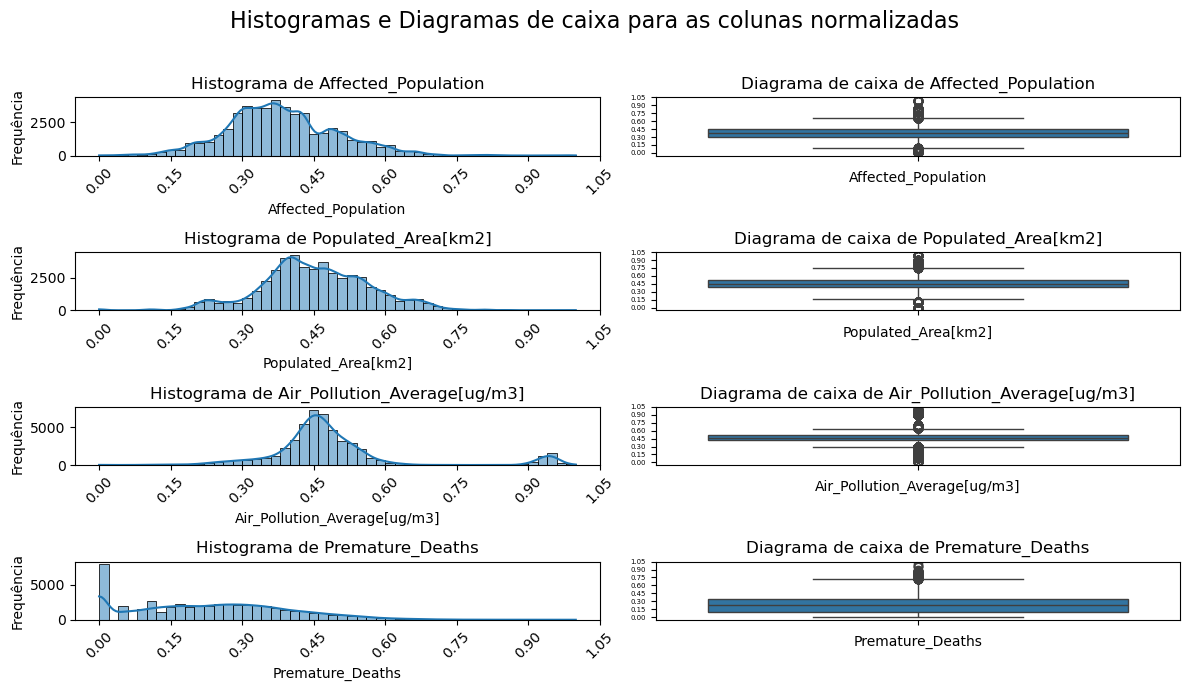

In [7]:
# Aplicar log1p (log(1 + x)) para reduzir o impacto de valores extremos
dados_log = dados[numericFeatures].apply(lambda x: np.log1p(x))

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
dados_scaled = pd.DataFrame(scaler.fit_transform(dados_log), columns=numericFeatures)

num_features = len(numericFeatures)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 3 + num_features))
fig.suptitle("Histogramas e Diagramas de caixa para as colunas normalizadas", fontsize=16)

for i, column in enumerate(numericFeatures):

    sns.histplot(dados_scaled[column], ax=axes[i, 0], kde=True, bins=50)
    axes[i, 0].set_title(f"Histograma de {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Frequência")
    axes[i, 0].tick_params(axis='x', labelrotation=45)
    axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(10))

    sns.boxplot(y=dados_scaled[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Diagrama de caixa de {column}")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params(axis='y', labelsize=5)
    axes[i, 1].yaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

#### Análise Bivariável

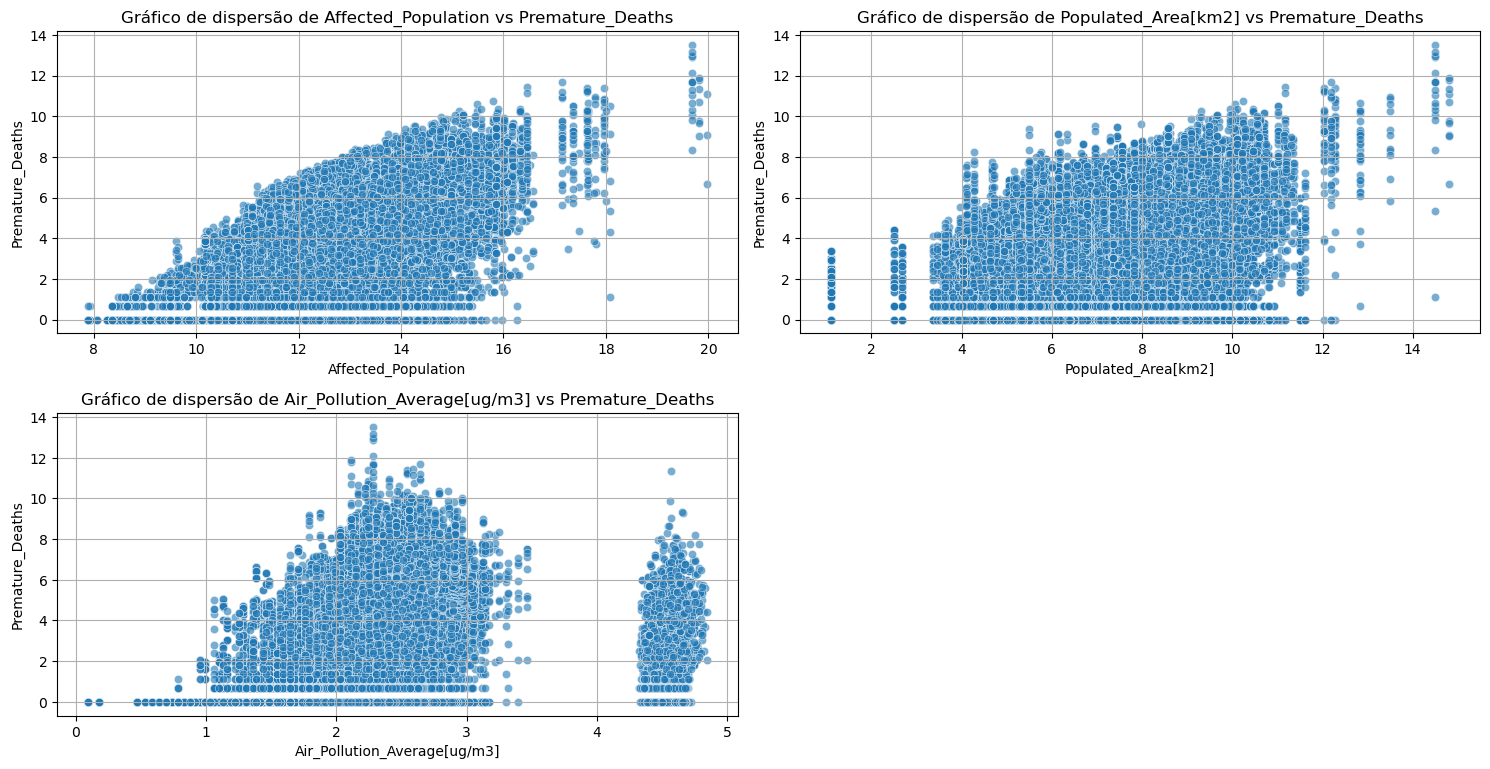

In [8]:
goalAttrib = 'Premature_Deaths'

plt.figure(figsize=(15,15))
numericFeaturesWOValue = [f for f in numericFeatures if f != goalAttrib]
for i, feature in enumerate(numericFeaturesWOValue):
    rows = (len(numericFeaturesWOValue) + 1) # Adjust rows to handle odd number of features
    plt.subplot(rows,2,i+1)
    sns.scatterplot(x=dados_log[feature], y=dados_log[goalAttrib], alpha=0.6)
    plt.title("Gráfico de dispersão de " + feature + " vs " + goalAttrib)
    plt.xlabel(feature)
    plt.ylabel(goalAttrib)
    plt.grid()
plt.tight_layout()

### 4.1.3. Pré-processamento dos dados

In [9]:
# Remover outliers
print(f"Número de linhas antes da remoção de outliers: {len(dados)}")

for col in numericFeatures:
    Q1 = dados[col].quantile(0.25)
    Q3 = dados[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (dados[col] >= (Q1 - 1.5 * IQR)) & (dados[col] <= (Q3 + 1.5 * IQR))
    dados = dados[filtro]

print(f"Número de linhas após remoção de outliers: {len(dados)}")

Número de linhas antes da remoção de outliers: 49140
Número de linhas após remoção de outliers: 30917


### 4.1.4. Agrupamento dos dados em zonas

In [10]:
westEuDados = dados[dados['Country'].isin(['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland'])]
eastEuDados = dados[dados['Country'].isin(['Poland', 'Czechia', 'Hungary'])]
soutEuDados = dados[dados['Country'].isin(['Greece', 'Spain', 'Italy', 'Portugal'])]
nortEuDados = dados[dados['Country'].isin(['Sweden', 'Denmark', 'Northern Europe', 'Finland'])]

### 4.2.2 - Com o método k-fold cross validation obter um modelo de regressão linear simples para a variável Premature_Deaths usando a variável Affected_Population dos países do Southern Europe

In [11]:
goalAttr = soutEuDados.columns[7]
feature = soutEuDados.columns[4]

print(f"Goal attribute: {goalAttr}")
print(f"Feature: {feature}")


Goal attribute: Premature_Deaths
Feature: Affected_Population


#### Divisão dos dados (Holdout: 70% Train / 30% Test)

In [ ]:
from sklearn.model_selection import train_test_split

y = soutEuDados[goalAttr]
X = soutEuDados[[feature]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train set size: ' + str(X_train.shape) + "x_test_size" + str(X_test.shape))
print('Test set size: ' + str(y_train.shape) + "y_test_size" + str(y_test.shape))

Train set size: (3966, 1)x_test_size(1700, 1)
Test set size: (3966,)y_test_size(1700,)


### Modelo de Regressão Linear Simples

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

print(f"Função linear média: {goalAttr} = {np.round(lr.coef_, 8)} * {feature} + {np.round(lr.intercept_, 2)}")

Função linear média: Premature_Deaths = [5.349e-05] * Affected_Population + 16.64


#### Visualização da reta e da dispersão de dados de teste

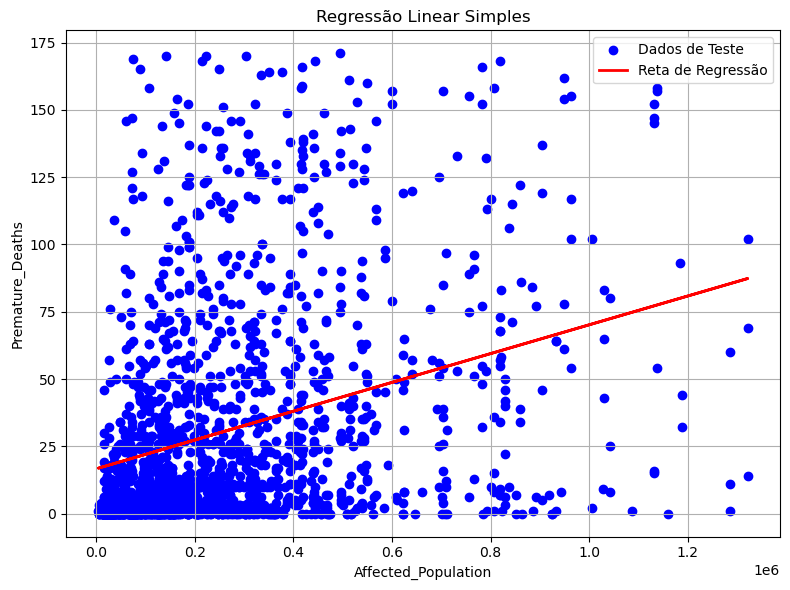

In [14]:
y_pred_test = lr.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Dados de Teste')
plt.plot(X_test, y_pred_test, color='red', linewidth=2, label='Reta de Regressão')
plt.xlabel('Affected_Population')
plt.ylabel('Premature_Deaths')
plt.title('Regressão Linear Simples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Calcular o MAE e o RMSE com o K-Fold Cross Validation

In [15]:
from sklearn.model_selection import KFold

def split_into_k_folds(data, k):

    kf = KFold(n_splits=k, shuffle=True)

    folds = []
    for train_index, test_index in kf.split(data):
        folds.append((train_index, test_index))
    
    return folds

##### Divisão em K-Folds

In [16]:
K=10
kFolds = split_into_k_folds(X_train, K)
for train_idx, test_idx in kFolds:
    print({len(train_idx), len(test_idx)})
    print(train_idx)
    print(test_idx)

{3569, 397}
[   0    1    2 ... 3963 3964 3965]
[  12   25   29   33   40   48   65   69   81   84   90  112  126  137
  139  169  185  206  214  223  224  225  264  281  314  315  317  331
  346  348  356  370  372  375  382  383  386  425  443  446  451  466
  470  504  505  518  528  542  543  554  559  560  615  634  647  648
  675  680  688  703  715  723  738  748  758  791  831  853  866  867
  875  878  879  880  900  922  950  965  967  988  992  994 1010 1013
 1021 1024 1035 1036 1064 1065 1098 1099 1100 1107 1112 1118 1132 1134
 1138 1139 1141 1144 1152 1164 1186 1220 1233 1243 1248 1260 1279 1282
 1294 1311 1316 1318 1323 1339 1347 1358 1360 1364 1369 1389 1400 1404
 1410 1427 1448 1450 1455 1470 1477 1485 1497 1503 1505 1510 1513 1536
 1537 1562 1576 1579 1582 1589 1594 1598 1601 1604 1613 1621 1636 1644
 1661 1667 1670 1679 1691 1693 1697 1706 1711 1727 1730 1742 1743 1751
 1761 1764 1776 1778 1784 1790 1793 1795 1796 1803 1809 1824 1864 1870
 1877 1890 1892 1897 1924 192

In [21]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

coefs = []
intercepts = []

for train_idx, test_idx in kFolds:
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    lr.fit(X_train_fold, y_train_fold)
    coefs.append(lr.coef_[0])
    intercepts.append(lr.intercept_)

coef_mean = np.mean(coefs)
coef_std = np.std(coefs)
intercept_mean = np.mean(intercepts)
intercept_std = np.std(intercepts)

##### Calcular o MAE e o RMSE

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Previsão nos dados de teste
y_pred_test = coef_mean * X_test + intercept_mean

# Calcular MAE e RMSE
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"MAE: {np.round(mae, 3)}")
print(f"RMSE: {np.round(rmse, 3)}")

MAE: 28.307
RMSE: 38.178
